In [1]:
import pandas as pd
import os
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Navegar hasta la raíz del proyecto 
WORKSPACE = os.path.abspath(os.path.join(os.getcwd(), '../../'))

# Definir la ruta de la carpeta de datos
DATA_FOLDER = os.path.join(WORKSPACE, 'data')

print("Workspace:", WORKSPACE)
print("Data folder:", DATA_FOLDER)

Workspace: /home/jovyan/work/mlds6
Data folder: /home/jovyan/work/mlds6/data


In [14]:
# Cargar el dataset y eliminar filas con valores vacíos en 'PTPM_CON'
df = pd.read_csv(os.path.join(DATA_FOLDER, 'data_promedios.csv'), usecols=['PTPM_CON', 'PTPM_CON_1D', 'PTPM_CON_3D', 'PTPM_CON_7D', 'PTPM_CON_15D', 'PTPM_CON_30D','Fecha', 'CodigoEstacion']) 
df = df.dropna() 

# Asignar la columna 'Fecha' como el índice
df['Fecha'] = pd.to_datetime(df['Fecha'])  
df = df.set_index('Fecha')

# Verifica el DataFrame resultante
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13048112 entries, 2000-01-31 to 2023-12-31
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CodigoEstacion  int64  
 1   PTPM_CON        float64
 2   PTPM_CON_1D     float64
 3   PTPM_CON_3D     float64
 4   PTPM_CON_7D     float64
 5   PTPM_CON_15D    float64
 6   PTPM_CON_30D    float64
dtypes: float64(6), int64(1)
memory usage: 796.4 MB
None


In [4]:
# Función para reemplazar valores atípicos usando la fórmula basada en IQR
def reemplazar_valores_atipicos(grupo):
    # Calcular Q1, Q3 y IQR
    Q1 = grupo['PTPM_CON'].quantile(0.25)
    Q3 = grupo['PTPM_CON'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límite para identificar valores atípicos
    limite_superior = Q3 + 1.5 * IQR
    
    # Calcular el percentil 99
    P99 = grupo['PTPM_CON'].quantile(0.99)
    
    # Identificar valores atípicos
    atipicos = grupo[(grupo['PTPM_CON'] < 0) | (grupo['PTPM_CON'] > limite_superior)]
    reemplazos = len(atipicos)
    
    # Reemplazar valores atípicos por el percentil 99
    grupo['PTPM_CON'] = grupo['PTPM_CON'].apply(
        lambda x: P99 if x < 0 or x > limite_superior else x
    )
    
    return grupo, reemplazos

# Aplicar la función a cada estación
valores_atipicos = {}
df_filtrado = pd.DataFrame()

for estacion, grupo in df.groupby('CodigoEstacion'):
    grupo_reemplazado, reemplazos = reemplazar_valores_atipicos(grupo)
    valores_atipicos[estacion] = reemplazos
    df_filtrado = pd.concat([df_filtrado, grupo_reemplazado])

print(f"Valores atípicos reemplazados: {sum(valores_atipicos.values())}")

Valores atípicos reemplazados: 1771839


In [5]:
# Definir el rango de fechas
fecha_inicio = '2000-01-31'
fecha_fin = '2023-12-31'

# Calcular el número total de días en el rango
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)
total_dias = len(rango_fechas)

# Total de estaciones iniciales
total_estaciones_iniciales = df['CodigoEstacion'].nunique()
df_filtrado = pd.DataFrame()

# Filtrar estaciones que cumplen el criterio de al menos 80% de datos en el rango de fechas
def estacion_con_suficientes_datos(grupo):
    datos_en_rango = len(grupo)
    return datos_en_rango / total_dias >= 0.8

# Identificar estaciones que cumplen el criterio
estaciones_validas = df.groupby('CodigoEstacion').filter(estacion_con_suficientes_datos)['CodigoEstacion'].unique()

# Filtrar el DataFrame conservando solo las estaciones válidas
df_filtrado = df[df['CodigoEstacion'].isin(estaciones_validas)]

# Imprimir el número de estaciones eliminadas
print(f"Estaciones con menos del 80% de datos entre 2000-01-31 a 2023-12-31 eliminadas : {total_estaciones_iniciales - len(estaciones_validas)}")

Estaciones con menos del 80% de datos entre 2000-01-31 a 2023-12-31 eliminadas : 281


In [6]:
# Identificar estaciones donde más del 90% de los valores son 0
estaciones_0 = df_filtrado.groupby('CodigoEstacion')['PTPM_CON'].apply(lambda x: (x <= 0.1).mean() > 0.90)
estaciones_0 = estaciones_0[estaciones_0].index

# Eliminar estas estaciones del DataFrame
df_filtrado = df_filtrado[~df_filtrado['CodigoEstacion'].isin(estaciones_0)]

# Imprimir la cantidad de estaciones eliminadas
print(f"Estaciones con persistencia de ceros eliminadas : {len(estaciones_0)}")

Estaciones con persistencia de ceros eliminadas : 20


In [7]:
def process_station_group(station, group):
    """
    Procesa una estación individual y calcula la correlación entre PTPM_CON y el resto de variables numéricas.

    Args:
        station: Código de la estación a procesar.
        group (pd.DataFrame): Subgrupo del DataFrame para la estación.
        min_rows (int): Número mínimo de filas requeridas después de eliminar NaNs.

    Returns:
        tuple: (código_estación, correlaciones) o (None, None) si no cumple criterios.
    """
    # Eliminar columnas no deseadas
    exclude_cols = ['CodigoEstacion', 'Fecha']

    # Seleccionar solo columnas numéricas excepto las excluidas
    numeric_cols = group.select_dtypes(include=[np.number]).columns
    numeric_cols = numeric_cols[~numeric_cols.isin(exclude_cols)]

    # Verificar que la columna PTPM_CON esté en el DataFrame
    if 'PTPM_CON' not in numeric_cols:
        return None, None

    # Calcular correlaciones entre PTPM_CON y las demás columnas
    correlations = {}
    for col in numeric_cols:
        if col != 'PTPM_CON':
            # Eliminar filas con NaN solo para las dos columnas involucradas
            df_clean = group[['PTPM_CON', col]].dropna()

            # Calcular correlación y agregar al diccionario
            correlation_value = df_clean['PTPM_CON'].corr(df_clean[col])
            correlations[col] = correlation_value

    # Verificar si se calcularon correlaciones
    if len(correlations) == 0:
        return None, None

    return station, correlations

def process_all_stations(df):
    """
    Procesa todas las estaciones en paralelo utilizando multiprocessing y calcula la correlación de PTPM_CON.

    Args:
        df (pd.DataFrame): DataFrame completo.
        min_rows (int): Número mínimo de filas requeridas después de eliminar NaNs.

    Returns:
        dict: Diccionario con las correlaciones por estación.
    """
    # Agrupar por estación en lugar de filtrar repetidamente
    grouped = df.groupby('CodigoEstacion')

    # Definir el número de núcleos a utilizar
    num_cores = cpu_count()

    # Usar un pool de workers para paralelizar el proceso
    with Pool(processes=num_cores) as pool:
        # Usar chunksize para distribuir las estaciones en lotes más pequeños
        results = pool.starmap(process_station_group, [(station, group) for station, group in grouped])

    # Filtrar resultados nulos y construir el diccionario final
    return {station: corr for station, corr in results if station is not None}


def generate_summary_table(correlations):
    """
    Genera una tabla con la correlación máxima, mínima y promedio para cada variable.

    Args:
        correlations (dict): Diccionario de correlaciones por estación.

    Returns:
        pd.DataFrame: Tabla con las estadísticas por variable.
    """
    summary_data = {
        'Variable': [],
        'Correlación Máxima': [],
        'Correlación Mínima': [],
        'Correlación Promedio': []
    }

    # Crear un DataFrame para almacenar todas las correlaciones por variable
    all_correlations = pd.DataFrame()

    for station, station_corrs in correlations.items():
        temp_df = pd.DataFrame(station_corrs, index=[station])
        all_correlations = pd.concat([all_correlations, temp_df])

    # Iterar por cada variable y calcular la máxima, mínima y promedio
    for col in all_correlations.columns:
        max_corr_value = all_correlations[col].max()
        min_corr_value = all_correlations[col].min()
        avg_corr_value = all_correlations[col].mean()

        # Agregar datos a la tabla resumen
        summary_data['Variable'].append(col)
        summary_data['Correlación Máxima'].append(max_corr_value)
        summary_data['Correlación Mínima'].append(min_corr_value)
        summary_data['Correlación Promedio'].append(avg_corr_value)

    # Convertir a DataFrame
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [8]:
correlaciones = process_all_stations(df_filtrado)
tabla_resumen = generate_summary_table(correlaciones).sort_values('Correlación Promedio', ascending=False)
tabla_resumen

,Variable,Correlación Máxima,Correlación Mínima,Correlación Promedio
3,PTPM_CON_15D,0.487812,0.018945,0.182998
2,PTPM_CON_7D,0.494783,0.012801,0.180596
4,PTPM_CON_30D,0.450837,0.024721,0.180406
1,PTPM_CON_3D,0.516197,-0.010574,0.168739
0,PTPM_CON_1D,0.537002,-0.052421,0.145866


In [9]:
# Definir el umbral de correlación
umbral = 0.3

# Obtener las estaciones a eliminar basadas en el diccionario de correlaciones
estaciones_a_eliminar = [
    estacion for estacion, correlacion in correlaciones.items()
    if any(correlacion[variable] < umbral for variable in correlacion)
]

# Filtrar el DataFrame para eliminar las estaciones que cumplen la condición
df_filtrado = df_filtrado[~df_filtrado['CodigoEstacion'].isin(estaciones_a_eliminar)]

# Imprimir el número de estaciones eliminadas
print(f"Estaciones con correlación menor a 0.3 eliminadas : {len(estaciones_a_eliminar)}")

Estaciones con correlación menor a 0.3 eliminadas : 1343


In [10]:
print(f"Número de estaciones antes del filtrado: {df['CodigoEstacion'].nunique()}")
print(f"Número de estaciones después del filtrado: {df_filtrado['CodigoEstacion'].nunique()}")

Número de estaciones antes del filtrado: 1682
Número de estaciones después del filtrado: 38


In [11]:
# Guardar df_filtrado como un archivo CSV
df_filtrado.to_csv(DATA_FOLDER + '/data_filtrado.csv', index_label='Fecha')

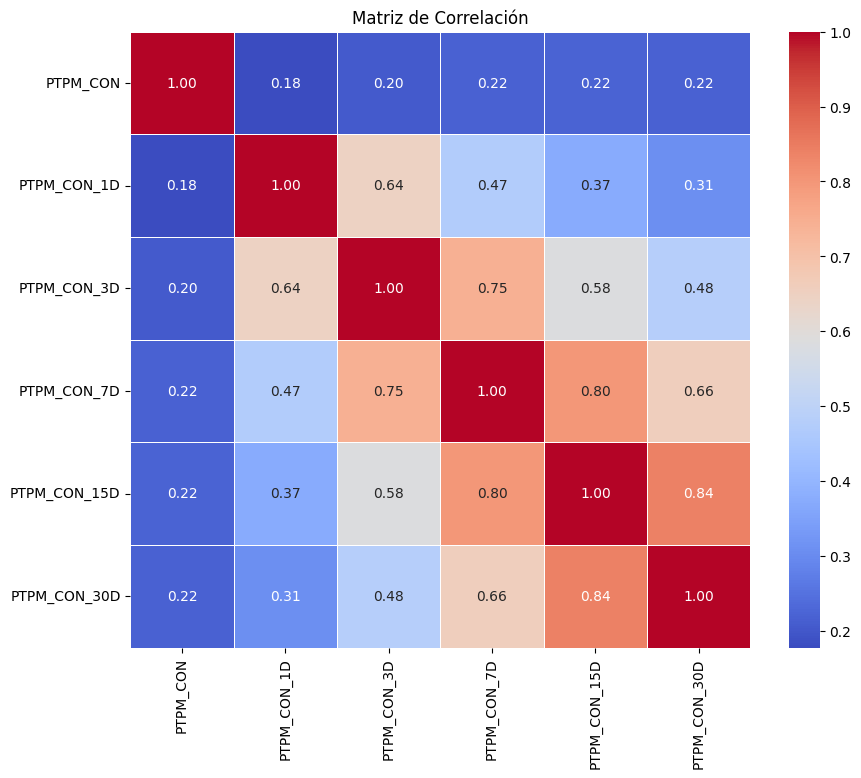

In [15]:
columns = df.filter(regex='PTPM').columns
df[columns] = df.groupby('CodigoEstacion')[columns].transform(lambda x: x / x.max())

# Calcular la matriz de correlación
correlation_matrix = df[columns].corr()

# Graficar la matriz de correlación usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.savefig('correlation_matrix.png', bbox_inches='tight')